In [1]:
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory)

Current Working Directory: /Users/simonriley/Desktop/dv304/Food_Detection


In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
import ssl
import certifi

#Set the SSl certificate authority file
ssl._create_default_https_context = ssl._create_unverified_context
ssl._create_default_https_context().load_verify_locations(certifi.where())

In [4]:
image_dir = Path('./input/food41/images')

# Creating File DataFrame

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(500, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
image_df

,Filepath,Label
0,input/food41/images/prime rib/1823178.jpg,prime rib
1,input/food41/images/caesar salad/2340232.jpg,caesar salad
2,input/food41/images/caesar salad/2448338.jpg,caesar salad
3,input/food41/images/eggs benedict/1610000.jpg,eggs benedict
4,input/food41/images/huevos rancheros/255853.jpg,huevos rancheros
...,...,...
50495,input/food41/images/beef carpaccio/1391584.jpg,beef carpaccio
50496,input/food41/images/foie gras/546651.jpg,foie gras
50497,input/food41/images/pad thai/3882704.jpg,pad thai
50498,input/food41/images/club sandwich/2400826.jpg,club sandwich


In [7]:
image_df['Label'].value_counts()

Label
prime rib          500
foie gras          500
red velvet cake    500
frozen yogurt      500
cup cakes          500
                  ... 
edamame            500
chicken curry      500
pho                500
chocolate cake     500
peking duck        500
Name: count, Length: 101, dtype: int64

In [8]:
image_df['Label'].unique()

array(['prime rib', 'caesar salad', 'eggs benedict', 'huevos rancheros',
       'tacos', 'samosa', 'crab cakes', 'omelette', 'ramen',
       'french onion soup', 'hot and sour soup', 'hamburger',
       'onion rings', 'guacamole', 'sushi', 'tuna tartare', 'bruschetta',
       'poutine', 'clam chowder', 'macaroni and cheese', 'beef tartare',
       'hummus', 'greek salad', 'breakfast burrito', 'mussels', 'baklava',
       'hot dog', 'pulled pork sandwich', 'chocolate cake', 'pho',
       'chicken curry', 'edamame', 'carrot cake', 'beignets',
       'fish and chips', 'macarons', 'grilled salmon', 'gyoza',
       'french toast', 'pad thai', 'donuts', 'cannoli',
       'strawberry shortcake', 'churros', 'cheese plate',
       'lobster bisque', 'filet mignon', 'beef carpaccio', 'waffles',
       'tiramisu', 'dumplings', 'ceviche', 'fried calamari', 'cheesecake',
       'chocolate mousse', 'pancakes', 'croque madame', 'oysters',
       'spaghetti bolognese', 'nachos', 'seaweed salad', 'pizza

# Train-Test Split

In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 28280 validated image filenames belonging to 101 classes.
Found 7070 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.


# Modeling

In [12]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

# Training

In [14]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
884/884 [==============================] - 263s 296ms/step - loss: 2.6473 - accuracy: 0.3534 - val_loss: 2.1591 - val_accuracy: 0.4440
Epoch 2/100
884/884 [==============================] - 280s 317ms/step - loss: 1.8503 - accuracy: 0.5186 - val_loss: 1.9687 - val_accuracy: 0.5001
Epoch 3/100
884/884 [==============================] - 2178s 2s/step - loss: 1.5968 - accuracy: 0.5752 - val_loss: 1.9418 - val_accuracy: 0.5052
Epoch 4/100
884/884 [==============================] - 2142s 2s/step - loss: 1.4014 - accuracy: 0.6192 - val_loss: 1.9632 - val_accuracy: 0.5161
Epoch 5/100
884/884 [==============================] - 2870s 3s/step - loss: 1.2447 - accuracy: 0.6562 - val_loss: 2.0336 - val_accuracy: 0.5083
Epoch 6/100
884/884 [==============================] - 3182s 4s/step - loss: 1.0990 - accuracy: 0.6937 - val_loss: 2.1085 - val_accuracy: 0.5025


In [15]:
model.save('food_detection_model.hdf5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Results

In [16]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 50.69%


In [17]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

474/474 [==============================] - 108s 228ms/step


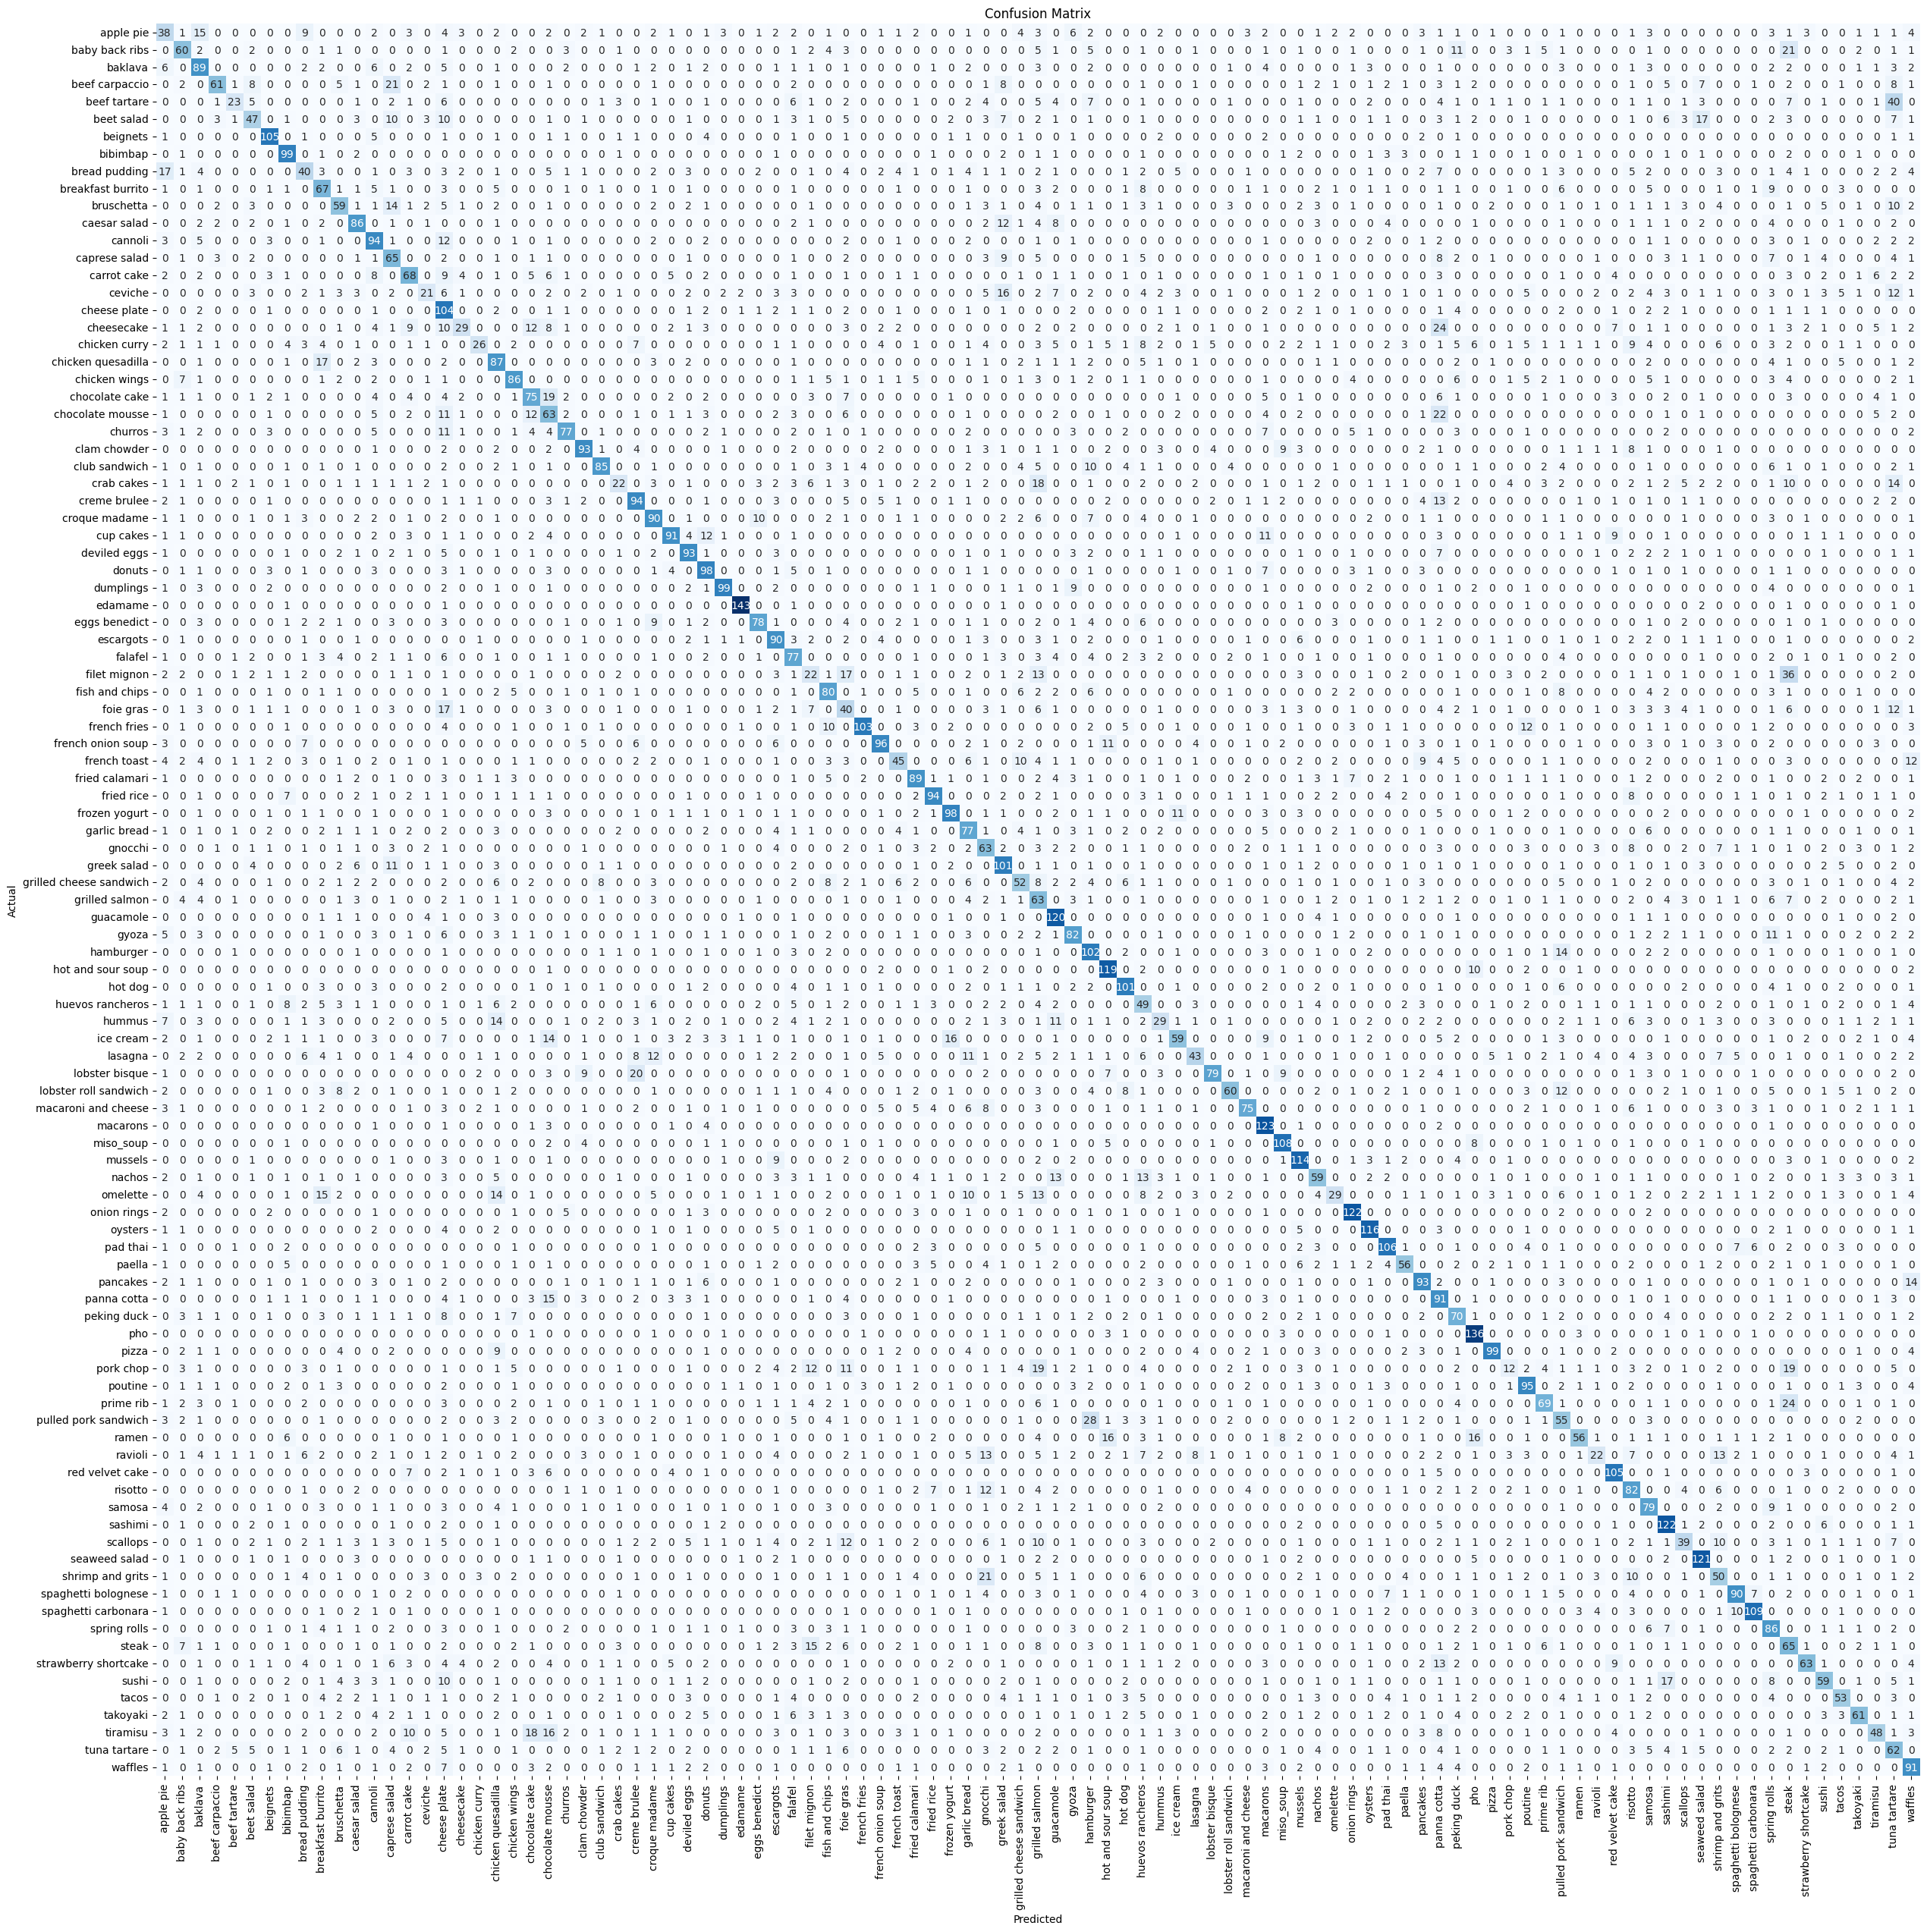

In [18]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(101) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple pie       0.26      0.25      0.26       152
         baby back ribs       0.48      0.41      0.44       147
                baklava       0.46      0.55      0.50       161
         beef carpaccio       0.73      0.39      0.51       158
           beef tartare       0.55      0.16      0.24       146
             beet salad       0.46      0.30      0.36       159
               beignets       0.70      0.77      0.73       137
               bibimbap       0.61      0.76      0.68       130
          bread pudding       0.33      0.25      0.29       158
      breakfast burrito       0.39      0.47      0.42       143
             bruschetta       0.45      0.38      0.41       157
           caesar salad       0.57      0.58      0.57       149
                cannoli       0.47      0.63      0.53       150
          caprese salad       0.37      0.